# How to use Numpy with TatukGIS DK for Python
This Jupyter Notebook offers an example of the possibilities using the Numpy (Numerical Python) open-source Python library with the new TatukGIS SDK for Python edition to perform geoscientific calculations.

Jupyter Notebook is an open-source web-based interactive computational environment for creating notebook documents, usually ending with the ".ipynb" extension.. These notebooks may contain an ordered list of input/output cells with code, text (using Markdown), mathematics, plots and rich media.
Jupyter Notebook is similar to the notebook interface of other programs such as Maple, Mathematica, or Matlab.

For a more, see the Jupyter Notebook documentation: https://jupyter-notebook.readthedocs.io/en/latest/notebook.htmland <br> and in-depth tour of Jupyter Notebooks: https://hub.gke2.mybinder.org/user/ipython-ipython-in-depth-4vn16qqh/notebooks/binder/Index.ipynb

### Import required modules

In [1]:
import tatukgis.pdk as pdk
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from numbers import Number
np.seterr(divide='ignore', invalid='ignore');

In [2]:
band_desc = {
    "B1": "Coastal / Aerosol",
    "B2": "Visible blue",
    "B3": "Visible green",
    "B4": "Visible red",
    "B5": "Near-infrared",
    "B6": "Short wavelength infrared",
    "B7": "Short wavelength infrared",
    "B8": "Panchromatic",
    "B9": "Cirrus",
    "B10": "Long wavelength infrared",
    "B11": "Long wavelength infrared"
}

### Add helper functions for loading raster data to numpy array and normalizing matrices

In [3]:
def band_to_array(band_path):
    """Reads a raster from path and returns
    a band name and an array with the band data.

    Args:
        band_path (str): path to a raster image

    Returns:
        str, numpy.ndarray: band name, band data as numpy array
    """
    # get band name from long path
    # "LC08_L1TP_014032_20191024_20191030_01_T1_B1.TIF" 
    band_name = Path(band_path).stem.split("_")[7]
    
    # create a pixel layer
    lp = pdk.TGIS_Utils.GisCreateLayer(band_name, band_path)
    lp.Open()
    
    # interpretate a pixel lauyer as a grid
    lp.Interpretation = pdk.TGIS_LayerPixelInterpretation().Grid
    lp.Params.Pixel.GridBand = 1
    
    # lock a whole grid for reading
    lp_lock = lp.LockPixels(lp.Extent, lp.CS, False)
    try:
        # get grid cells as a numpy array
        band_arr = lp_lock.AsArray()
    finally:
        # remember to unlock!
        lp.UnlockPixels(lp_lock)
    
    return band_name, band_arr


def norm(arr, scale=2**16, factor=1.0):
    """Normalizes arr in range 0..1.

    Args:
        arr (numpy.ndarray): numpy array representation
                             of the grid or the pixel layer
        scale (Number)     : divide an arr by the scale (divisor)
        factor (Number)    : multiply arr by a factor (multiplicand)

    Returns:
        numpy.ndarray: normalized array
    """
    res_arr = (arr / scale * factor)
    res_arr[res_arr>1] = 1
    return res_arr

### Load Landsat 8 data

In [4]:
landsat_paths = glob.glob(
    pdk.TGIS_Utils.GisSamplesDataDirDownload() +
    r"World\Countries\USA\States\New York\Landsat 8\*.tif"
)

# list paths
print(*landsat_paths, sep="\n")

# store all landsat bands in a dictionary with band name as a key
bands = {name: arr for (name, arr) in map(band_to_array, landsat_paths)}

E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New York\Landsat 8\LC08_L1TP_014032_20191024_20191030_01_T1_B10_cut.TIF
E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New York\Landsat 8\LC08_L1TP_014032_20191024_20191030_01_T1_B11_cut.TIF
E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New York\Landsat 8\LC08_L1TP_014032_20191024_20191030_01_T1_B1_cut.TIF
E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New York\Landsat 8\LC08_L1TP_014032_20191024_20191030_01_T1_B2_cut.TIF
E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New York\Landsat 8\LC08_L1TP_014032_20191024_20191030_01_T1_B3_cut.TIF
E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New York\Landsat 8\LC08_L1TP_014032_20191024_20191030_01_T1_B4_cut.TIF
E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New York\Landsat 8\LC08_L1TP_014032_20191024_20191030_01_T1_B5_cut.TIF
E:\GisData\TatukGIS\Data\Samples11\World\Countries\USA\States\New Y

### Vizualize all bands

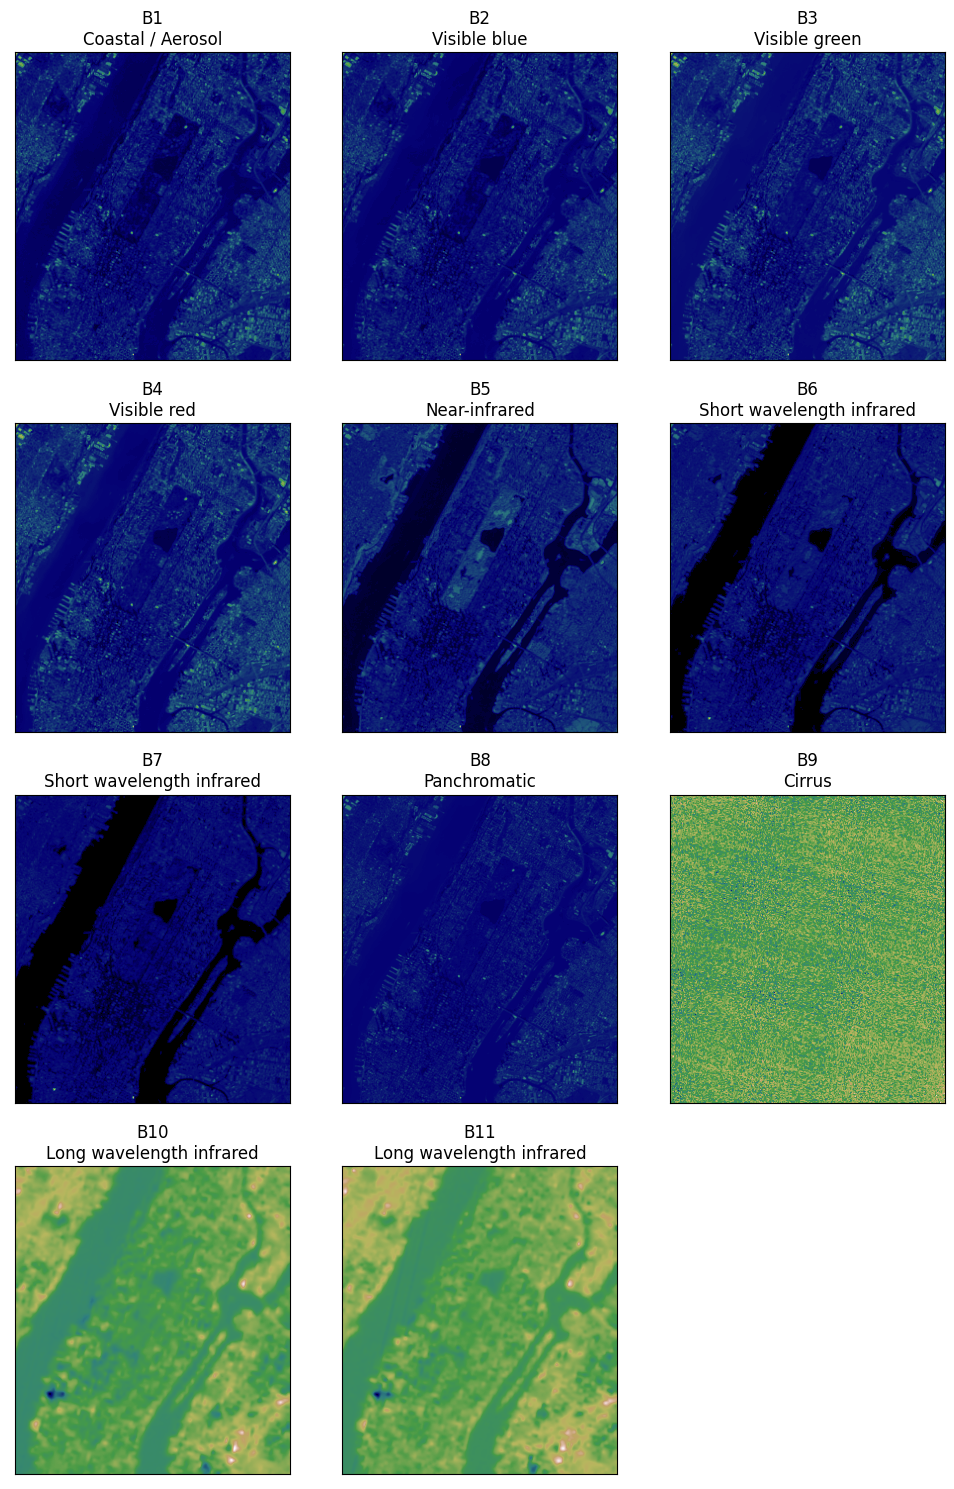

In [5]:
fig, axes = plt.subplots(
    4, 3,
    subplot_kw={'xticks': [], 'yticks': []},
    figsize=(10,15)
)
for i in range(len(bands)):
    band_name = f"B{i+1}"
    band_title = f"{band_name}\n{band_desc[band_name]}"
    if not band_name in bands:
        continue
    band_arr = bands[band_name]
    
    axes[i // 3, i % 3].imshow(band_arr, cmap="gist_earth")
    axes[i // 3, i % 3].set_title(band_title)

axes[3, 2].remove()  # don't display empty axis

fig.tight_layout()
plt.show()

### Create and display RGB Composite Image

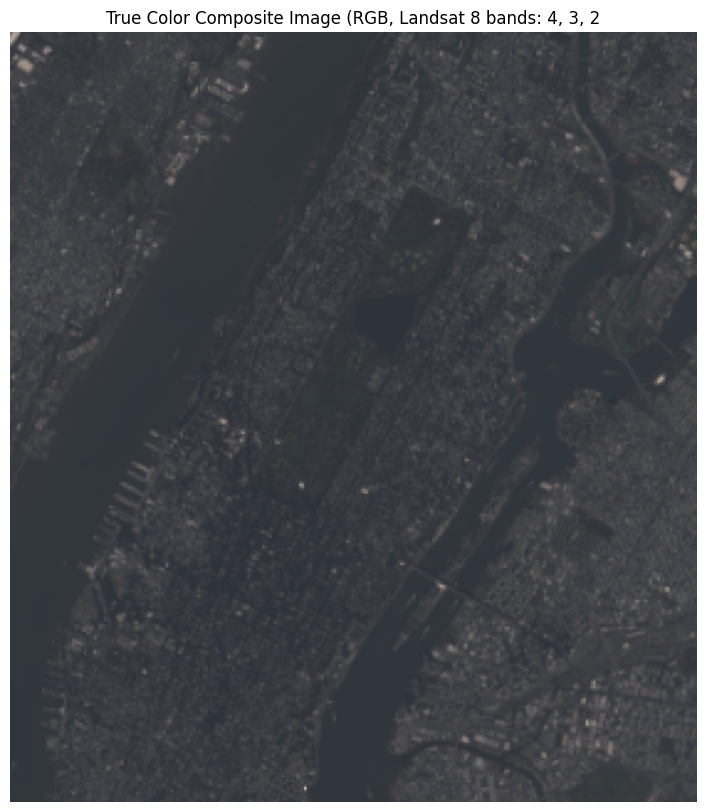

In [6]:
plt.rcParams['figure.figsize'] = [10, 10]

rgb = norm(
    np.stack((bands["B4"], bands["B3"], bands["B2"]), axis=-1),
    factor=2
)
plt.imshow(rgb)
plt.axis('off')
plt.title("True Color Composite Image (RGB, Landsat 8 bands: 4, 3, 2")
plt.show()

### Create and display False Composite Image

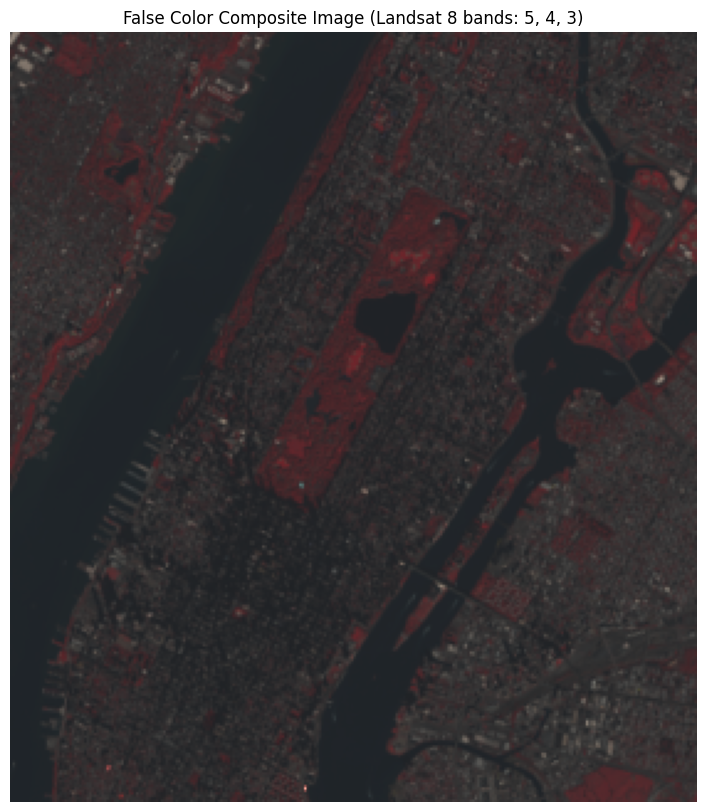

In [7]:
false_composite = norm(
    np.stack((bands["B5"], bands["B4"], bands["B3"]), axis=-1),
    factor=1.5
)
plt.imshow(false_composite)
plt.axis('off')
plt.title("False Color Composite Image (Landsat 8 bands: 5, 4, 3)")
plt.show()

### Calculate and display Normalized Difference Vegetation Index (NDVI)

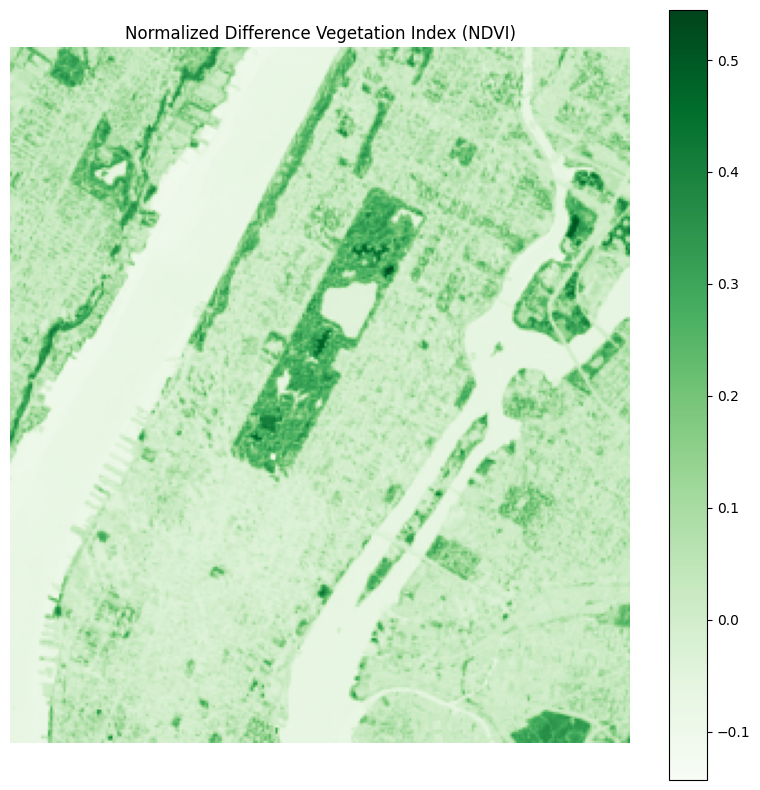

In [8]:
ndvi = (bands["B5"] - bands["B4"]) / (bands["B5"] + bands["B4"])
plt.imshow(ndvi, cmap="Greens")
plt.colorbar()
plt.axis('off')
plt.title("Normalized Difference Vegetation Index (NDVI)")
plt.show()

### Calculate and display Modified Normalized Difference Water Index (MNDWI)

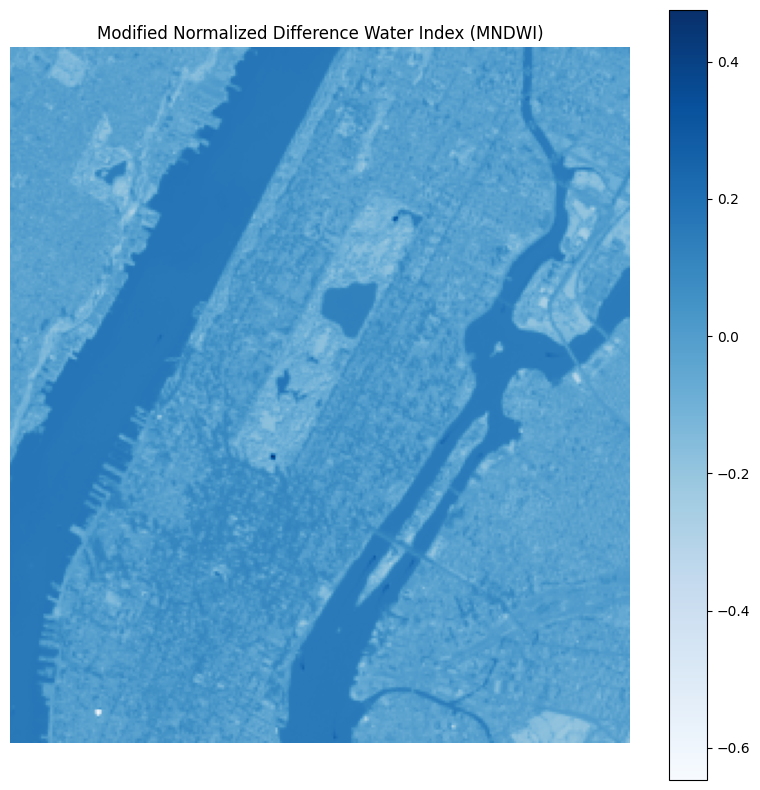

In [9]:
mndwi = (bands["B3"] - bands["B6"]) / (bands["B3"] + bands["B6"])
plt.imshow(mndwi, cmap="Blues")
plt.colorbar()
plt.axis('off')
plt.title("Modified Normalized Difference Water Index (MNDWI)")
plt.show()

### Extract water pixels

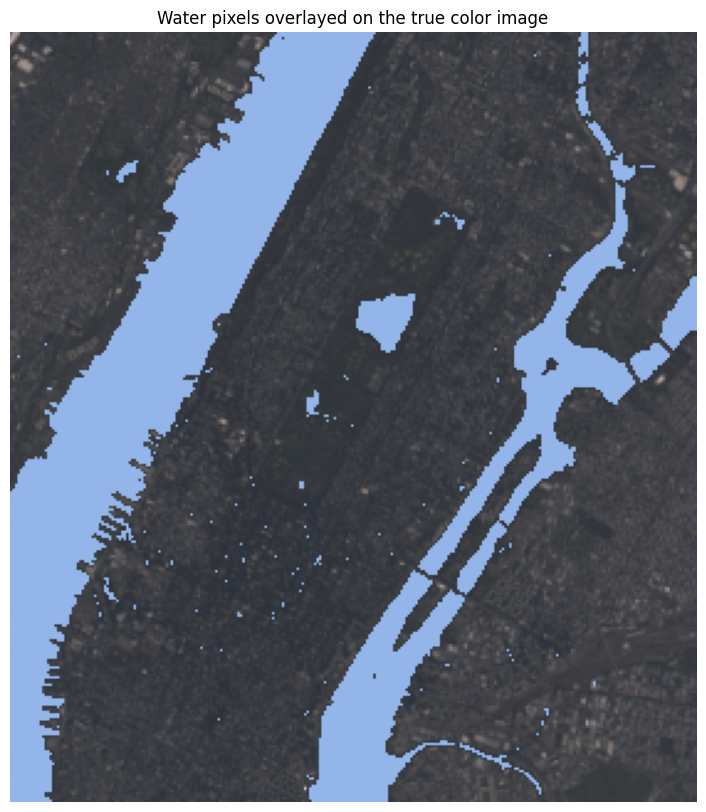

In [10]:
water_mask = mndwi > 0.11
rgb_water = rgb.copy()
rgb_water[water_mask] = np.array([147, 181, 234]) / 255.0
plt.imshow(rgb_water)
plt.axis('off')
plt.title("Water pixels overlayed on the true color image")
plt.show()

### Extract Built-up areas

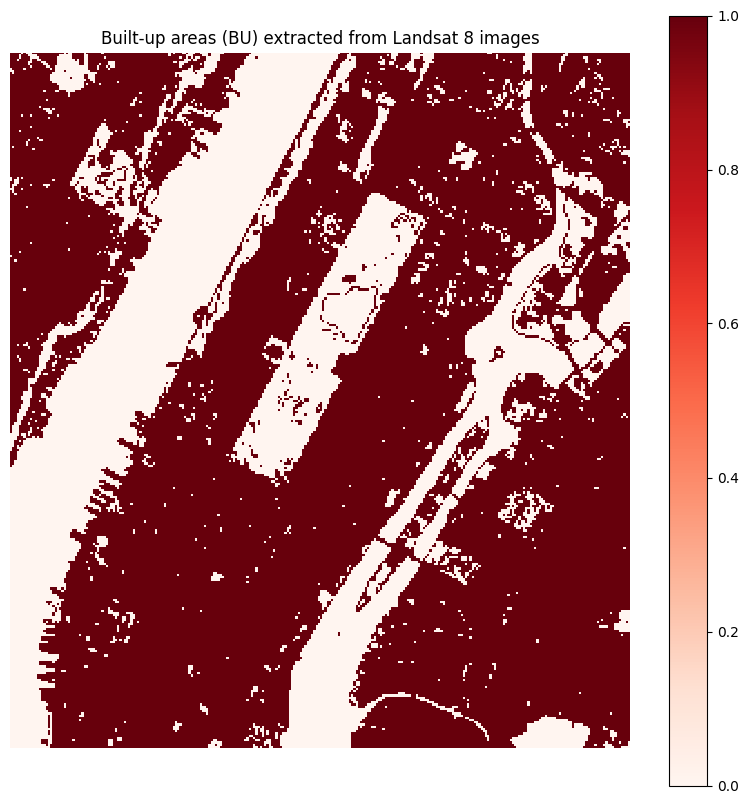

In [11]:
ndbi = (bands["B6"] - bands["B5"]) / (bands["B6"] + bands["B5"])
bu = ndbi - ndvi
builtup_mask = bu > -0.25
bu[builtup_mask] = 1
bu[~builtup_mask] = 0
bu[water_mask] = 0

plt.imshow(bu, cmap="Reds", interpolation="nearest")
plt.colorbar()
plt.axis('off')
plt.title("Built-up areas (BU) extracted from Landsat 8 images")
plt.show()